## Tutorial 23 - Aircraft Aerodynamic Analysis
Welcome to this tutorial on performing aerodynamic analysis of a turbofan aircraft using RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs.

---

## 1. Header and Imports


The **Imports** section is divided into two parts: general-purpose Python libraries and simulation-specific libraries.

In [1]:
import matplotlib.cm as cm   
import numpy as np
from copy import deepcopy
import matplotlib.pyplot  as plt
import os

## 2. RCAIDE Imports

The **RCAIDE Imports** section includes the core modules needed for the simulation. These libraries provide specialized classes and tools for building, analyzing, and running aircraft models.

### Key Imports:

1. **RCAIDE**: The core package is imported directly. This approach allows us to access specific classes and methods from RCAIDE without repeatedly importing individual components at the top of the script.

2. **`Units` Module**: The Units module is a standardized way to handle unit conversions within RCAIDE. It ensures consistent units across all inputs and outputs, reducing the likelihood of conversion errors.

In [2]:
import RCAIDE
from RCAIDE.Framework.Core import Units , Data   
from RCAIDE.Library.Methods.Powertrain.Propulsors.Turbofan          import design_turbofan
from RCAIDE.Library.Methods.Performance                            import aircraft_aerodynamic_analysis 
from RCAIDE.Library.Methods.Geometry.Planform import wing_planform
from RCAIDE.Library.Plots                                          import *        

# Vehicle Setup

The **`vehicle_setup`** function defines the baseline configuration of the aircraft. This section builds the vehicle step-by-step by specifying its components, geometric properties, and high-level parameters.

A detailed description of the vehicle setup is provided in the [Tutorial 1](tutorial_01_turbofan_aircraft.ipynb).

In [3]:
def vehicle_setup(): 
    
    # ------------------------------------------------------------------
    #   Initialize the Vehicle
    # ------------------------------------------------------------------    
    
    vehicle = RCAIDE.Vehicle()
    vehicle.tag = 'Boeing_737-800'
    # ################################################# Vehicle-level Properties #################################################   
    vehicle.mass_properties.max_takeoff               = 79015.8 * Units.kilogram  
    vehicle.mass_properties.takeoff                   = 79015.8 * Units.kilogram    
    vehicle.mass_properties.operating_empty           = 62746.4 * Units.kilogram  
    vehicle.mass_properties.max_zero_fuel             = 62732.0 * Units.kilogram 
    vehicle.mass_properties.cargo                     = 10000.  * Units.kilogram  
    vehicle.mass_properties.center_of_gravity         = [[21,0, 0, 0]]
    vehicle.flight_envelope.ultimate_load             = 3.75
    vehicle.flight_envelope.positive_limit_load       = 2.5 
    vehicle.flight_envelope.design_mach_number        = 0.78 
    vehicle.flight_envelope.design_cruise_altitude    = 35000*Units.feet
    vehicle.flight_envelope.design_range              = 3500 * Units.nmi
    vehicle.reference_area                            = 124.862 * Units['meters**2']   
    vehicle.passengers                                = 170
    vehicle.systems.control                           = "fully powered" 
    vehicle.systems.accessories                       = "medium range"
    
     # ################################################# Landing Gear #############################################################   
    # ------------------------------------------------------------------        
    #  Landing Gear
    # ------------------------------------------------------------------  
    main_gear               = RCAIDE.Library.Components.Landing_Gear.Main_Landing_Gear()
    main_gear.tire_diameter = 1.12000 * Units.m
    main_gear.strut_length  = 1.8 * Units.m 
    main_gear.units         = 2    # Number of main landing gear
    main_gear.wheels        = 2    # Number of wheels on the main landing gear
    vehicle.append_component(main_gear)  

    nose_gear               = RCAIDE.Library.Components.Landing_Gear.Nose_Landing_Gear()       
    nose_gear.tire_diameter = 0.6858 * Units.m
    nose_gear.units         = 1    # Number of nose landing gear
    nose_gear.wheels        = 2    # Number of wheels on the nose landing gear
    nose_gear.strut_length  = 1.3 * Units.m 
    vehicle.append_component(nose_gear)
    # ################################################# Wings ##################################################################### 
    # ------------------------------------------------------------------
    #   Main Wing
    # ------------------------------------------------------------------
 
    wing                                  = RCAIDE.Library.Components.Wings.Main_Wing()
    wing.tag                              = 'main_wing' 
    wing.aspect_ratio                     = 10.18
    wing.sweeps.quarter_chord             = 25 * Units.deg
    wing.thickness_to_chord               = 0.1
    wing.taper                            = 0.1 
    wing.spans.projected                  = 34.32 
    wing.chords.root                      = 7.760 * Units.meter
    wing.chords.tip                       = 0.782 * Units.meter
    wing.chords.mean_aerodynamic          = 4.235 * Units.meter 
    wing.areas.reference                  = 124.862
    wing.areas.wetted                     = 225.08 
    wing.twists.root                      = 4.0 * Units.degrees
    wing.twists.tip                       = 0.0 * Units.degrees 
    wing.origin                           = [[13.61,0,-0.5]]
    wing.aerodynamic_center               = [0,0,0] 
    wing.vertical                         = False
    wing.symmetric                        = True
    wing.high_lift                        = True 
    wing.dynamic_pressure_ratio           = 1.0
    # Wing Segments
    root_airfoil                          = RCAIDE.Library.Components.Airfoils.Airfoil()
    ospath                                = os.path.abspath(os.path.join('Notebook'))
    separator                             = os.path.sep
    rel_path = os.path.dirname(ospath) + separator + '..' + separator + '..' + separator + 'VnV' + separator + 'Vehicles' + separator
    root_airfoil.coordinate_file          = rel_path  + 'Airfoils' + separator + 'B737a.txt'
    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'Root'
    segment.percent_span_location         = 0.0
    segment.twist                         = 4. * Units.deg
    segment.root_chord_percent            = 1.
    segment.thickness_to_chord            = 0.1
    segment.dihedral_outboard             = 2.5 * Units.degrees
    segment.sweeps.quarter_chord          = 28.225 * Units.degrees
    segment.thickness_to_chord            = .1
    segment.append_airfoil(root_airfoil)
    wing.append_segment(segment)

    yehudi_airfoil                        = RCAIDE.Library.Components.Airfoils.Airfoil()
    yehudi_airfoil.coordinate_file        = rel_path+ 'Airfoils' + separator + 'B737b.txt'
    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'Yehudi'
    segment.percent_span_location         = 0.324
    segment.twist                         = 0.047193 * Units.deg
    segment.root_chord_percent            = 0.5
    segment.thickness_to_chord            = 0.1
    segment.dihedral_outboard             = 5.5 * Units.degrees
    segment.sweeps.quarter_chord          = 25. * Units.degrees
    segment.thickness_to_chord            = .1
    segment.append_airfoil(yehudi_airfoil)
    wing.append_segment(segment)

    mid_airfoil                           = RCAIDE.Library.Components.Airfoils.Airfoil()
    mid_airfoil.coordinate_file           = rel_path + 'Airfoils' + separator + 'B737c.txt'
    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'Section_2'
    segment.percent_span_location         = 0.963
    segment.twist                         = 0.00258 * Units.deg
    segment.root_chord_percent            = 0.220
    segment.thickness_to_chord            = 0.1
    segment.dihedral_outboard             = 5.5 * Units.degrees
    segment.sweeps.quarter_chord          = 56.75 * Units.degrees
    segment.thickness_to_chord            = .1
    segment.append_airfoil(mid_airfoil)
    wing.append_segment(segment)

    tip_airfoil                           =  RCAIDE.Library.Components.Airfoils.Airfoil()
    tip_airfoil.coordinate_file           = rel_path + 'Airfoils' + separator + 'B737d.txt'
    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'Tip'
    segment.percent_span_location         = 1.
    segment.twist                         = 0. * Units.degrees
    segment.root_chord_percent            = 0.10077
    segment.thickness_to_chord            = 0.1
    segment.dihedral_outboard             = 0.
    segment.sweeps.quarter_chord          = 0.
    segment.thickness_to_chord            = .1
    segment.append_airfoil(tip_airfoil)
    wing.append_segment(segment)
    
    # control surfaces -------------------------------------------
    slat                          = RCAIDE.Library.Components.Wings.Control_Surfaces.Slat()
    slat.tag                      = 'slat'
    slat.span_fraction_start      = 0.2
    slat.span_fraction_end        = 0.963
    slat.deflection               = 0.0 * Units.degrees
    slat.chord_fraction           = 0.075
    wing.append_control_surface(slat)

    flap                          = RCAIDE.Library.Components.Wings.Control_Surfaces.Flap()
    flap.tag                      = 'flap'
    flap.span_fraction_start      = 0.2
    flap.span_fraction_end        = 0.7
    flap.deflection               = 0.0 * Units.degrees
    flap.configuration_type       = 'double_slotted'
    flap.chord_fraction           = 0.30
    wing.append_control_surface(flap)

    aileron                       = RCAIDE.Library.Components.Wings.Control_Surfaces.Aileron()
    aileron.tag                   = 'aileron'
    aileron.span_fraction_start   = 0.7
    aileron.span_fraction_end     = 0.963
    aileron.deflection            = 0.0 * Units.degrees
    aileron.chord_fraction        = 0.16
    wing.append_control_surface(aileron)

    # add to vehicle
    vehicle.append_component(wing)
     # ------------------------------------------------------------------
    #  Horizontal Stabilizer
    # ------------------------------------------------------------------

    wing     = RCAIDE.Library.Components.Wings.Horizontal_Tail()
    wing.tag = 'horizontal_stabilizer'

    wing.aspect_ratio            = 4.99
    wing.sweeps.quarter_chord    = 28.2250 * Units.deg  
    wing.thickness_to_chord      = 0.08
    wing.taper                   = 0.3333  
    wing.spans.projected         = 14.4 
    wing.chords.root             = 4.2731 
    wing.chords.tip              = 1.4243 
    wing.chords.mean_aerodynamic = 8.0 
    wing.areas.reference         = 41.49
    wing.areas.exposed           = 59.354    # Exposed area of the horizontal tail
    wing.areas.wetted            = 71.81     # Wetted area of the horizontal tail
    wing.twists.root             = 3.0 * Units.degrees
    wing.twists.tip              = 3.0 * Units.degrees 
    wing.origin                  = [[33.02,0,1.466]]
    wing.aerodynamic_center      = [0,0,0] 
    wing.vertical                = False
    wing.symmetric               = True 
    wing.dynamic_pressure_ratio  = 0.9


    # Wing Segments
    segment                        = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                    = 'root_segment'
    segment.percent_span_location  = 0.0
    segment.twist                  = 0. * Units.deg
    segment.root_chord_percent     = 1.0
    segment.dihedral_outboard      = 8.63 * Units.degrees
    segment.sweeps.quarter_chord   = 28.2250  * Units.degrees 
    segment.thickness_to_chord     = .1
    wing.append_segment(segment)

    segment                        = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                    = 'tip_segment'
    segment.percent_span_location  = 1.
    segment.twist                  = 0. * Units.deg
    segment.root_chord_percent     = 0.3333               
    segment.dihedral_outboard      = 0 * Units.degrees
    segment.sweeps.quarter_chord   = 0 * Units.degrees  
    segment.thickness_to_chord     = .1
    wing.append_segment(segment)      

    # control surfaces -------------------------------------------
    elevator                       = RCAIDE.Library.Components.Wings.Control_Surfaces.Elevator()
    elevator.tag                   = 'elevator'
    elevator.span_fraction_start   = 0.09
    elevator.span_fraction_end     = 0.92
    elevator.deflection            = 0.0  * Units.deg
    elevator.chord_fraction        = 0.3
    wing.append_control_surface(elevator)

    # add to vehicle
    vehicle.append_component(wing)

    # ------------------------------------------------------------------
    #   Vertical Stabilizer
    # ------------------------------------------------------------------

    wing = RCAIDE.Library.Components.Wings.Vertical_Tail()
    wing.tag = 'vertical_stabilizer'

    wing.aspect_ratio            = 1.98865
    wing.sweeps.quarter_chord    = 31.2  * Units.deg   
    wing.thickness_to_chord      = 0.08
    wing.taper                   = 0.1183

    wing.spans.projected         = 8.33
    wing.total_length            = wing.spans.projected 
    
    wing.chords.root             = 10.1 
    wing.chords.tip              = 1.20 
    wing.chords.mean_aerodynamic = 4.0

    wing.areas.reference         = 34.89
    wing.areas.wetted            = 57.25 
    
    wing.twists.root             = 0.0 * Units.degrees
    wing.twists.tip              = 0.0 * Units.degrees

    wing.origin                  = [[26.944,0,1.54]]
    wing.aerodynamic_center      = [0,0,0]

    wing.vertical                = True
    wing.symmetric               = False
    wing.t_tail                  = False

    wing.dynamic_pressure_ratio  = 1.0


    # Wing Segments
    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'root'
    segment.percent_span_location         = 0.0
    segment.twist                         = 0. * Units.deg
    segment.root_chord_percent            = 1.
    segment.dihedral_outboard             = 0 * Units.degrees
    segment.sweeps.quarter_chord          = 61.485 * Units.degrees  
    segment.thickness_to_chord            = .1
    wing.append_segment(segment)

    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'segment_1'
    segment.percent_span_location         = 0.2962
    segment.twist                         = 0. * Units.deg
    segment.root_chord_percent            = 0.45
    segment.dihedral_outboard             = 0. * Units.degrees
    segment.sweeps.quarter_chord          = 31.2 * Units.degrees   
    segment.thickness_to_chord            = .1
    wing.append_segment(segment)

    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'segment_2'
    segment.percent_span_location         = 1.0
    segment.twist                         = 0. * Units.deg
    segment.root_chord_percent            = 0.1183 
    segment.dihedral_outboard             = 0.0 * Units.degrees
    segment.sweeps.quarter_chord          = 0.0    
    segment.thickness_to_chord            = .1  
    wing.append_segment(segment)

    # add to vehicle
    vehicle.append_component(wing)
     # ################################################# Fuselage ################################################################ 
    
    fuselage                                    = RCAIDE.Library.Components.Fuselages.Fuselage() 
    fuselage.number_coach_seats                 = vehicle.passengers 
    fuselage.seats_abreast                      = 6
    fuselage.seat_pitch                         = 1     * Units.meter 
    fuselage.fineness.nose                      = 1.6
    fuselage.fineness.tail                      = 2. 
    fuselage.lengths.nose                       = 6.4   * Units.meter
    fuselage.lengths.tail                       = 8.0   * Units.meter
    fuselage.lengths.total                      = 38.02 * Units.meter  
    fuselage.lengths.fore_space                 = 6.    * Units.meter
    fuselage.lengths.aft_space                  = 5.    * Units.meter
    fuselage.width                              = 3.74  * Units.meter
    fuselage.heights.maximum                    = 3.74  * Units.meter
    fuselage.effective_diameter                 = 3.74     * Units.meter
    fuselage.areas.side_projected               = 142.1948 * Units['meters**2'] 
    fuselage.areas.wetted                       = 446.718  * Units['meters**2'] 
    fuselage.areas.front_projected              = 12.57    * Units['meters**2']  
    fuselage.differential_pressure              = 5.0e4 * Units.pascal 
    fuselage.heights.at_quarter_length          = 3.74 * Units.meter
    fuselage.heights.at_three_quarters_length   = 3.65 * Units.meter
    fuselage.heights.at_wing_root_quarter_chord = 3.74 * Units.meter

    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()  
    segment.tag                                 = 'segment_0'    
    segment.percent_x_location                  = 0.0000
    segment.percent_z_location                  = -0.00144 
    segment.height                              = 0.0100 
    segment.width                               = 0.0100  
    fuselage.segments.append(segment)   
    
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_1'    
    segment.percent_x_location                  = 0.00576 
    segment.percent_z_location                  = -0.00144 
    segment.height                              = 0.7500
    segment.width                               = 0.6500
    fuselage.segments.append(segment)   
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_2'   
    segment.percent_x_location                  = 0.02017 
    segment.percent_z_location                  = 0.00000 
    segment.height                              = 1.52783 
    segment.width                               = 1.20043 
    fuselage.segments.append(segment)      
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_3'   
    segment.percent_x_location                  = 0.03170 
    segment.percent_z_location                  = 0.00000 
    segment.height                              = 1.96435 
    segment.width                               = 1.52783 
    fuselage.segments.append(segment)   

    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_4'   
    segment.percent_x_location                  = 0.04899 	
    segment.percent_z_location                  = 0.00431 
    segment.height                              = 2.72826 
    segment.width                               = 1.96435 
    fuselage.segments.append(segment)   
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_5'   
    segment.percent_x_location                  = 0.07781 
    segment.percent_z_location                  = 0.00861 
    segment.height                              = 3.49217 
    segment.width                               = 2.61913 
    fuselage.segments.append(segment)     
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_6'   
    segment.percent_x_location                  = 0.10375 
    segment.percent_z_location                  = 0.01005 
    segment.height                              = 3.70130 
    segment.width                               = 3.05565 
    fuselage.segments.append(segment)             
     
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_7'   
    segment.percent_x_location                  = 0.16427 
    segment.percent_z_location                  = 0.01148 
    segment.height                              = 3.92870 
    segment.width                               = 3.71043 
    fuselage.segments.append(segment)    
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_8'   
    segment.percent_x_location                  = 0.22478 
    segment.percent_z_location                  = 0.01148 
    segment.height                              = 3.92870 
    segment.width                               = 3.92870 
    fuselage.segments.append(segment)   
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_9'     
    segment.percent_x_location                  = 0.69164 
    segment.percent_z_location                  = 0.01292
    segment.height                              = 3.81957
    segment.width                               = 3.81957
    fuselage.segments.append(segment)     
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_10'     
    segment.percent_x_location                  = 0.71758 
    segment.percent_z_location                  = 0.01292
    segment.height                              = 3.81957
    segment.width                               = 3.81957
    fuselage.segments.append(segment)   
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_11'     
    segment.percent_x_location                  = 0.78098 
    segment.percent_z_location                  = 0.01722
    segment.height                              = 3.49217
    segment.width                               = 3.71043
    fuselage.segments.append(segment)    
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_12'     
    segment.percent_x_location                  = 0.85303
    segment.percent_z_location                  = 0.02296
    segment.height                              = 3.05565
    segment.width                               = 3.16478
    fuselage.segments.append(segment)             
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_13'     
    segment.percent_x_location                  = 0.91931 
    segment.percent_z_location                  = 0.03157
    segment.height                              = 2.40087
    segment.width                               = 1.96435
    fuselage.segments.append(segment)               
        
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_14'     
    segment.percent_x_location                  = 1.00 
    segment.percent_z_location                  = 0.04593
    segment.height                              = 1.09130
    segment.width                               = 0.21826
    fuselage.segments.append(segment)       
    
    # add to vehicle
    vehicle.append_component(fuselage)

    # ################################################# Energy Network #######################################################          
    #------------------------------------------------------------------------------------------------------------------------- 
    #  Turbofan Network
    #-------------------------------------------------------------------------------------------------------------------------   
    net                                         = RCAIDE.Framework.Networks.Fuel() 
    
    #------------------------------------------------------------------------------------------------------------------------- 
    # Fuel Distrubition Line 
    #------------------------------------------------------------------------------------------------------------------------- 
    fuel_line                                   = RCAIDE.Library.Components.Powertrain.Distributors.Fuel_Line()  
    
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Propulsor: Starboard Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------         
    turbofan                                    = RCAIDE.Library.Components.Powertrain.Propulsors.Turbofan() 
    turbofan.tag                                = 'starboard_propulsor'
    turbofan.active_fuel_tanks                  = ['fuel_tank']   
    turbofan.origin                             = [[13.72, 4.86,-1.1]] 
    turbofan.engine_length                      = 2.71     
    turbofan.bypass_ratio                       = 5.4    
    turbofan.design_altitude                    = 35000.0*Units.ft
    turbofan.design_mach_number                 = 0.78   
    turbofan.design_thrust                      = 35000.0* Units.N 
             
    # fan                
    fan                                         = RCAIDE.Library.Components.Powertrain.Converters.Fan()   
    fan.tag                                     = 'fan'
    fan.polytropic_efficiency                   = 0.93
    fan.pressure_ratio                          = 1.7   
    turbofan.fan                                = fan        
                   
    # working fluid                   
    turbofan.working_fluid                      = RCAIDE.Library.Attributes.Gases.Air() 
    ram                                         = RCAIDE.Library.Components.Powertrain.Converters.Ram()
    ram.tag                                     = 'ram' 
    turbofan.ram                                = ram 
          
    # inlet nozzle          
    inlet_nozzle                                = RCAIDE.Library.Components.Powertrain.Converters.Compression_Nozzle()
    inlet_nozzle.tag                            = 'inlet nozzle'
    inlet_nozzle.polytropic_efficiency          = 0.98
    inlet_nozzle.pressure_ratio                 = 0.98 
    turbofan.inlet_nozzle                       = inlet_nozzle 

    # low pressure compressor    
    low_pressure_compressor                       = RCAIDE.Library.Components.Powertrain.Converters.Compressor()    
    low_pressure_compressor.tag                   = 'lpc'
    low_pressure_compressor.polytropic_efficiency = 0.91
    low_pressure_compressor.pressure_ratio        = 1.9   
    turbofan.low_pressure_compressor              = low_pressure_compressor

    # high pressure compressor  
    high_pressure_compressor                       = RCAIDE.Library.Components.Powertrain.Converters.Compressor()    
    high_pressure_compressor.tag                   = 'hpc'
    high_pressure_compressor.polytropic_efficiency = 0.91
    high_pressure_compressor.pressure_ratio        = 10.0    
    turbofan.high_pressure_compressor              = high_pressure_compressor

    # low pressure turbine  
    low_pressure_turbine                           = RCAIDE.Library.Components.Powertrain.Converters.Turbine()   
    low_pressure_turbine.tag                       ='lpt'
    low_pressure_turbine.mechanical_efficiency     = 0.99
    low_pressure_turbine.polytropic_efficiency     = 0.93 
    turbofan.low_pressure_turbine                  = low_pressure_turbine
   
    # high pressure turbine     
    high_pressure_turbine                          = RCAIDE.Library.Components.Powertrain.Converters.Turbine()   
    high_pressure_turbine.tag                      ='hpt'
    high_pressure_turbine.mechanical_efficiency    = 0.99
    high_pressure_turbine.polytropic_efficiency    = 0.93 
    turbofan.high_pressure_turbine                 = high_pressure_turbine 

    # combustor  
    combustor                                      = RCAIDE.Library.Components.Powertrain.Converters.Combustor()   
    combustor.tag                                  = 'Comb'
    combustor.efficiency                           = 0.99 
    combustor.alphac                               = 1.0     
    combustor.turbine_inlet_temperature            = 1500
    combustor.pressure_ratio                       = 0.95
    combustor.fuel_data                            = RCAIDE.Library.Attributes.Propellants.Jet_A1()  
    turbofan.combustor                             = combustor

    # core nozzle
    core_nozzle                                    = RCAIDE.Library.Components.Powertrain.Converters.Expansion_Nozzle()   
    core_nozzle.tag                                = 'core nozzle'
    core_nozzle.polytropic_efficiency              = 0.95
    core_nozzle.pressure_ratio                     = 0.99  
    turbofan.core_nozzle                           = core_nozzle
             
    # fan nozzle             
    fan_nozzle                                     = RCAIDE.Library.Components.Powertrain.Converters.Expansion_Nozzle()   
    fan_nozzle.tag                                 = 'fan nozzle'
    fan_nozzle.polytropic_efficiency               = 0.95
    fan_nozzle.pressure_ratio                      = 0.99 
    turbofan.fan_nozzle                            = fan_nozzle 
    
    # design turbofan
    design_turbofan(turbofan)  
    # append propulsor to distribution line  
   
 
    # Nacelle 
    nacelle                                     = RCAIDE.Library.Components.Nacelles.Body_of_Revolution_Nacelle()
    nacelle.diameter                            = 2.05
    nacelle.length                              = 2.71
    nacelle.tag                                 = 'nacelle_1'
    nacelle.inlet_diameter                      = 2.0
    nacelle.origin                              = [[13.5,4.38,-1.5]] 
    nacelle.areas.wetted                        = 1.1*np.pi*nacelle.diameter*nacelle.length 
    nacelle_airfoil                             = RCAIDE.Library.Components.Airfoils.NACA_4_Series_Airfoil()
    nacelle_airfoil.NACA_4_Series_code          = '2410'
    nacelle.append_airfoil(nacelle_airfoil)  
    turbofan.nacelle                            = nacelle

    # append propulsor to network    
    net.propulsors.append(turbofan)  

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Propulsor: Port Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------      
    # copy turbofan
    turbofan_2                                  = deepcopy(turbofan)
    turbofan_2.active_fuel_tanks                = ['fuel_tank'] 
    turbofan_2.tag                              = 'port_propulsor' 
    turbofan_2.origin                           = [[13.72,-4.38,-1.1]]  # change origin 
    turbofan_2.nacelle.origin                   = [[13.5,-4.38,-1.5]]
         
    # append propulsor to network
    net.propulsors.append(turbofan_2)
  
    #------------------------------------------------------------------------------------------------------------------------- 
    #  Energy Source: Fuel Tank
    #------------------------------------------------------------------------------------------------------------------------- 
    # fuel tank
    fuel_tank                                        = RCAIDE.Library.Components.Powertrain.Sources.Fuel_Tanks.Fuel_Tank()
    fuel_tank.origin                                 = vehicle.wings.main_wing.origin  
    fuel_tank.fuel                                   = RCAIDE.Library.Attributes.Propellants.Jet_A1()   
    fuel_tank.fuel.mass_properties.mass              = vehicle.mass_properties.max_takeoff-vehicle.mass_properties.max_fuel
    fuel_tank.fuel.origin                            = vehicle.wings.main_wing.mass_properties.center_of_gravity      
    fuel_tank.fuel.mass_properties.center_of_gravity = vehicle.wings.main_wing.aerodynamic_center
    fuel_tank.volume                                 = fuel_tank.fuel.mass_properties.mass/fuel_tank.fuel.density   
    fuel_line.fuel_tanks.append(fuel_tank)
    
    #------------------------------------------------------------------------------------------------------------------------------------   
    # Assign propulsors to fuel line to network      
    fuel_line.assigned_propulsors =  [[turbofan.tag, turbofan_2.tag]]

    #------------------------------------------------------------------------------------------------------------------------------------   
    # Append fuel line to fuel line to network      
    net.fuel_lines.append(fuel_line)        
    
    # Append energy network to aircraft 
    vehicle.append_energy_network(net)       
    #------------------------------------------------------------------------------------------------------------------------- 
    # Done ! 
    #------------------------------------------------------------------------------------------------------------------------- 
      
    return vehicle

## Aerodynamic Analysis

With the vehicle setup complete, we can now perform the aerodynamic analysis. This involves evaluating the aerodynamic performance of the aircraft over a range of Mach numbers and angles of attack.

### Steps for Analysis

1. **Define Input Parameters**:
   - Specify a range of Mach numbers and angles of attack (`AoA`) for the analysis.

2. **Run the Aerodynamic Analysis**:
   - Use the `aircraft_aerodynamic_analysis` function to calculate key aerodynamic parameter, such as:
     - Lift Coefficient (`C_L`)
   - Perform the analysis for all combinations of Mach numbers and angles of attack.

3. **Organize Results**:
   - Store the computed aerodynamic data in a structured format, such as a dictionary or DataFrame, for easier visualization and interpretation.

4. **Visualize Results**:
   - Use the `plot_aircraft_aerodynamics` function to generate plots of the aerodynamic parameters across the defined ranges.

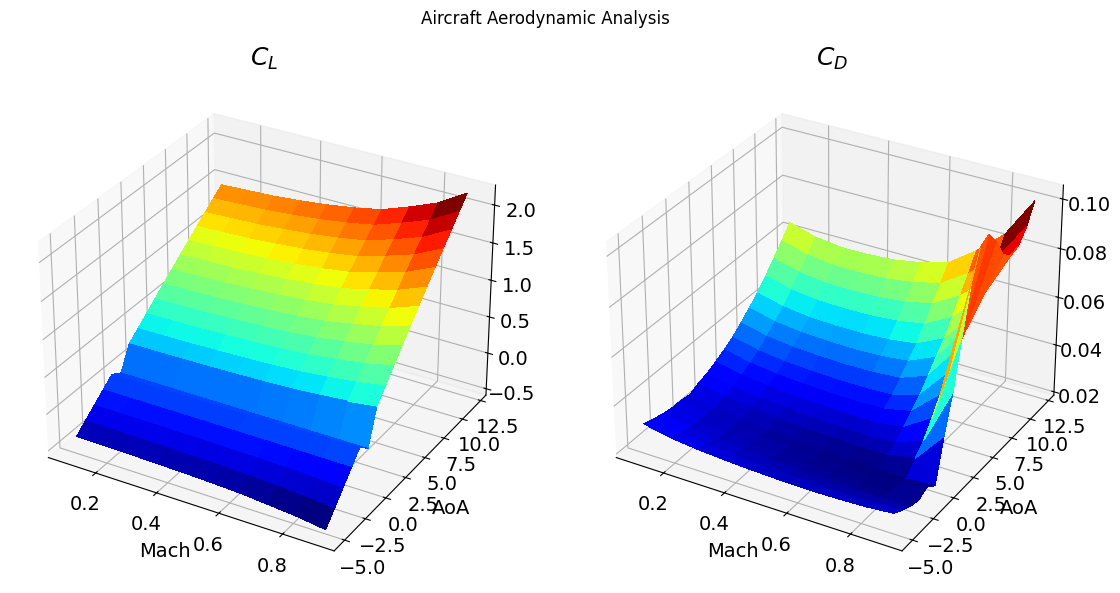

In [4]:
vehicle                           = vehicle_setup()  
for wing in vehicle.wings: 
         wing_planform(wing,overwrite_reference =  True) 
         if isinstance(wing, RCAIDE.Library.Components.Wings.Main_Wing):
            vehicle.reference_area = wing.areas.reference
Mach_number_range                 = np.atleast_2d(np.linspace(0.1, 0.9, 10)).T
angle_of_attack_range             = np.atleast_2d(np.linspace(-5, 12, 18)).T*Units.degrees 
control_surface_deflection_range  = np.atleast_2d(np.linspace(0,30,7)).T*Units.degrees 
aerodynamics_analysis_routine     = RCAIDE.Framework.Analyses.Aerodynamics.Vortex_Lattice_Method()
aerodynamics_analysis_routine.vehicle = vehicle
    
results                           = aircraft_aerodynamic_analysis(aerodynamics_analysis = aerodynamics_analysis_routine,
                                                                      angle_of_attack_range = angle_of_attack_range,
                                                                      Mach_number_range = Mach_number_range,
                                                                      control_surface_deflection_range= control_surface_deflection_range)
  
plot_aircraft_aerodynamics(results) 